In [6]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torchvision.models as models
import torch.optim as optim

from tqdm import tnrange, tqdm_notebook

import os
from PIL import Image, ImageOps
from skimage.color import rgb2lab, lab2rgb, rgb2gray, xyz2lab
from tqdm import tqdm
import h5py
import torch.utils.data as data
from color_utils import (torch_softmax2image,  lab2pil, ab2bin, 
    bin2ab, idx_to_lab, ColorLoss, pil2lab)
from dataset import  hd52numpy, hd52numpy,ColorizeDataSet, img2hdf5
from model import ColorizeRegressor

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
os.environ['TORCH_MODEL_ZOO'] =  "/home/ec2-user/SageMaker/efs/pytorch_model_zoo/"

## Load DataSet

In [3]:
#train_dir = "/home/ec2-user/data/train/imagenet"
train_dir = "/home/ec2-user/data/train/lukas"
ds_train = ColorizeDataSet(train_dir,  transform=transforms.Compose([
                            transforms.RandomRotation(15, expand=False),
                            transforms.RandomResizedCrop(256),
                            transforms.RandomHorizontalFlip(),
                           ]))
train_loader = data.DataLoader(ds_train,batch_size=16, shuffle=True, num_workers=8)
ds_test = ColorizeDataSet('/home/ec2-user/data/test/lukas',  transform=transforms.Compose([
                            transforms.Resize(299),
                            transforms.CenterCrop(256),
                           ]))
test_loader = data.DataLoader(ds_test,batch_size=16, shuffle=False)

## Colorization Classifier 

In [11]:
model = ColorizeRegressor(feature_cascade=(512, 256, 64, 64))

In [12]:
def get_validation_error(model):
    model.eval()
    loss = 0.0
    num = 0
    for inputs, labels in test_loader:
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        with torch.no_grad():
            a_out = model(inputs)
        _, yh = torch.max(a_out, 1)
        loss += criterion(a_out, labels).item() * labels.shape[0]
        num += labels.shape[0]
    print(f"Validation Loss: {loss/num}")
    return loss/num

def train(model, optimizer, criterion, epochs=10, lrs=None):
    val_loss, t_loss = [], []
    for e in range(epochs):
        print(f"epoch: {e}")
        running_loss = 0.0
        running_num = 1e-8
        if lrs is not None: lrs.step()
        pbar = tqdm_notebook(train_loader)
            
        for inputs, labels in pbar:
            pbar.set_description(f"loss: {running_loss/running_num}")
            model.train()
            inputs, labels = inputs.to('cuda'), labels.to('cuda') 

            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.shape[0]
            running_num += inputs.shape[0]
        tloss = running_loss/running_num
        vloss = get_validation_error(model)
        val_loss.append(vloss)
        t_loss.append(tloss)
    return pd.DataFrame({'loss': val_loss, 't_loss': t_loss})

In [14]:
model.cuda()
model.freeze_ft()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()
epochs = 4
loss_hist = train(model, optimizer, criterion, epochs, None)

epoch: 0


Process Process-46:
Process Process-45:
  File "/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process Process-47:
Process Process-42:
Process Process-43:
Traceback (most recent call last):
Process Process-41:
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-44:
  File "/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ec2-user/anaconda3/envs

  File "/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/skimage/color/colorconv.py", line 682, in rgb2xyz
    return _convert(xyz_from_rgb, arr)
  File "/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/skimage/color/colorconv.py", line 1035, in rgb2lab
    return xyz2lab(rgb2xyz(rgb), illuminant, observer)
  File "/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/skimage/color/colorconv.py", line 680, in rgb2xyz
    arr[mask] = np.power((arr[mask] + 0.055) / 1.055, 2.4)
  File "/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/skimage/color/colorconv.py", line 1035, in rgb2lab
    return xyz2lab(rgb2xyz(rgb), illuminant, observer)
  File "/home/ec2-user/workspace/imagenet-dl/color_utils.py", line 8, in pil2lab
    lab_hwc = rgb2lab(rgb_hwc)
  File "/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/PIL/Image.py", line 879, in convert
    self.load()
  File "/home/ec2-user/workspace/ima

KeyboardInterrupt: 

KeyboardInterrupt


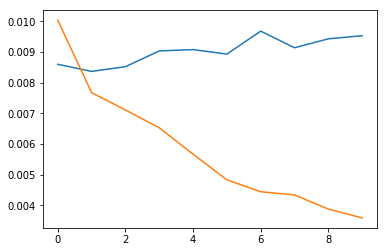

In [59]:
plt.plot(range(epochs), loss_hist['loss'])
plt.plot(range(epochs), loss_hist['t_loss'])

In [15]:
xb, yb = next(iter(test_loader))

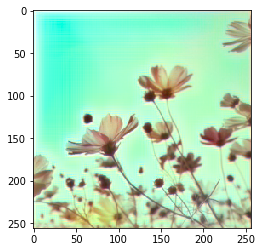

In [25]:
idx = 9
with torch.no_grad():
    model.eval()
    yc = model(xb.cuda())
    
x = np.double((xb.cpu().numpy())[idx,0,:])
y = np.double((yc.cpu().numpy())[idx,:])
img = lab2pil(x[:,:,None], y.transpose(1,2,0))
plt.imshow(img)


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 787 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


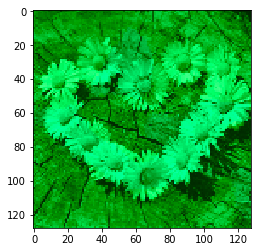

In [65]:
idx = 5
with torch.no_grad():
    model.eval()
    yc = model(xb.cuda())
    
x = (xb.cpu().numpy())[idx,0,:]
y = (yb.cpu().numpy())[idx,:]
yh = (yc.cpu()).numpy()[idx, :]
hist = yh.argmax(axis=0)
ab = bin2ab(hist)
plt.imshow(lab2pil(x[:,:,None], ab))

In [63]:
plt.imshow(lab2pil(x[:,:,None], bin2ab(y)))

AssertionError: need shape (H x W)